In [1]:
from __future__ import print_function
from numpy import *
%pylab inline
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# evaluates cubic bezier at t, return point
def q(ctrlPoly, t):
    return (1.0-t)**3 * ctrlPoly[0] + 3*(1.0-t)**2 * t * ctrlPoly[1] + 3*(1.0-t)* t**2 * ctrlPoly[2] + t**3 * ctrlPoly[3]


# evaluates cubic bezier first derivative at t, return point
def qprime(ctrlPoly, t):
    return 3*(1.0-t)**2 * (ctrlPoly[1]-ctrlPoly[0]) + 6*(1.0-t) * t * (ctrlPoly[2]-ctrlPoly[1]) + 3*t**2 * (ctrlPoly[3]-ctrlPoly[2])


# evaluates cubic bezier second derivative at t, return point
def qprimeprime(ctrlPoly, t):
    return 6*(1.0-t) * (ctrlPoly[2]-2*ctrlPoly[1]+ctrlPoly[0]) + 6*(t) * (ctrlPoly[3]-2*ctrlPoly[2]+ctrlPoly[1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from scipy.special import comb
from numpy import *


# Fit one (or more) Bezier curves to a set of points
def fitCurve(points, maxError):
    leftTangent = normalize(points[1] - points[0])
    rightTangent = normalize(points[-2] - points[-1])
    return fitCubic(points, leftTangent, rightTangent, maxError)


def fitCubic(points, leftTangent, rightTangent, error):
    # Use heuristic if region only has two points in it
    if (len(points) == 2):
        dist = linalg.norm(points[0] - points[1]) / 3.0
        bezCurve = [points[0], points[0] + leftTangent * dist, points[1] + rightTangent * dist, points[1]]
        return [bezCurve]

    # Parameterize points, and attempt to fit curve
    u = chordLengthParameterize(points)
    bezCurve = generateBezier(points, u, leftTangent, rightTangent)
    # Find max deviation of points to fitted curve
    maxError, splitPoint = computeMaxError(points, bezCurve, u)
    if maxError < error:
        return [bezCurve]

    # If error not too large, try some reparameterization and iteration
    if maxError < error**2:
        for i in range(20):
            uPrime = reparameterize(bezCurve, points, u)
            bezCurve = generateBezier(points, uPrime, leftTangent, rightTangent)
            maxError, splitPoint = computeMaxError(points, bezCurve, uPrime)
            if maxError < error:
                return [bezCurve]
            u = uPrime

    # Fitting failed -- split at max error point and fit recursively
    beziers = []
    centerTangent = normalize(points[splitPoint-1] - points[splitPoint+1])
    beziers += fitCubic(points[:splitPoint+1], leftTangent, centerTangent, error)
    beziers += fitCubic(points[splitPoint:], -centerTangent, rightTangent, error)

    return beziers

#Algorithm Used "Ramer–Douglas–Peucker":
def generateBezier(points, parameters, leftTangent, rightTangent):
    bezCurve = [points[0], None, None, points[-1]]

    # compute the A's
    A = zeros((len(parameters), 2, 2))
    for i, u in enumerate(parameters):
        A[i][0] = leftTangent  * 3*(1-u)**2 * u
        A[i][1] = rightTangent * 3*(1-u)    * u**2

    # Create the C and X matrices
    C = zeros((2, 2))
    X = zeros(2)

    for i, (point, u) in enumerate(zip(points, parameters)):
        C[0][0] += dot(A[i][0], A[i][0])
        C[0][1] += dot(A[i][0], A[i][1])
        C[1][0] += dot(A[i][0], A[i][1])
        C[1][1] += dot(A[i][1], A[i][1])

        tmp = point - q([points[0], points[0], points[-1], points[-1]], u)

        X[0] += dot(A[i][0], tmp)
        X[1] += dot(A[i][1], tmp)

    # Compute the determinants of C and X
    det_C0_C1 = C[0][0] * C[1][1] - C[1][0] * C[0][1]
    det_C0_X  = C[0][0] * X[1] - C[1][0] * X[0]
    det_X_C1  = X[0] * C[1][1] - X[1] * C[0][1]

    # Finally, derive alpha values
    alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
    alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

    # (if alpha is 0, you get coincident control points that lead to
    # divide by zero in any subsequent NewtonRaphsonRootFind() call. */
    segLength = linalg.norm(points[0] - points[-1])
    epsilon = 1.0e-6 * segLength
    if alpha_l < epsilon or alpha_r < epsilon:
        # fall back on standard (probably inaccurate) formula, and subdivide further if needed.
        bezCurve[1] = bezCurve[0] + leftTangent * (segLength / 3.0)
        bezCurve[2] = bezCurve[3] + rightTangent * (segLength / 3.0)

    else:
        # First and last control points of the Bezier curve are
        # positioned exactly at the first and last data points
        # Control points 1 and 2 are positioned an alpha distance out
        # on the tangent vectors, left and right, respectively
        bezCurve[1] = bezCurve[0] + leftTangent * alpha_l
        bezCurve[2] = bezCurve[3] + rightTangent * alpha_r

    return bezCurve

#now we update coordinates using Newton-Raphson Method.
def reparameterize(bezier, points, parameters):
    return [newtonRaphsonRootFind(bezier, point, u) for point, u in zip(points, parameters)]


#Newton Raphson Method
#Use Newton-Raphson iteration to find better root.
def newtonRaphsonRootFind(bez, point, u):
    
    d = q(bez, u)-point
    numerator = (d * qprime(bez, u)).sum()
    denominator = (qprime(bez, u)**2 + d * qprimeprime(bez, u)).sum()

    if denominator == 0.0:
        return u
    else:
        return u - numerator/denominator

#parameterize points by normalizing them in range [0,1].
def chordLengthParameterize(points):
    u = [0.0]
    for i in range(1, len(points)):
        u.append(u[i-1] + linalg.norm(points[i] - points[i-1]))

    for i, _ in enumerate(u):
        u[i] = u[i] / u[-1]

    return u


def computeMaxError(points, bez, parameters):
    maxDist = 0.0
    splitPoint = len(points)/2
    for i, (point, u) in enumerate(zip(points, parameters)):
        dist = linalg.norm(q(bez, u)-point)**2
        if dist > maxDist:
            maxDist = dist
            splitPoint = i

    return maxDist, splitPoint

#returns norm value (done)
def normalize(v):
    return v / linalg.norm(v)
 
#bezier_curve
    """
      Given a set of control points, return the
       bezier curve defined by the control points.
       nTimes is the number of time steps, defaults to 1000
    """
def bezier_curve(points, nTimes=1000):
    

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])
    #print(xPoints)
    #print(yPoints)
    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

#The Bernstein polynomial of n, i as a function of t
def bernstein_poly(i, n, t):
    
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

In [3]:
def ParseFile(filepath):
    data =[]
    label=[]
    
    with open(filepath,'r',encoding="utf8") as file:
        line= file.readline()
        
        
        while line:
            #print(line)
            
            val=0
            if(not(line.startswith("// Non-ASCII") or line.startswith("WORD") or line.startswith("// ASCII") or line.startswith(" NUMSTROKES")or line.startswith("  POINTS"))):
                line=file.readline()
                continue
            if( not (line.startswith("// Non-ASCII") or line.strip().endswith(('!', '\"', '$', '%', "\'", '(', ')', ',', '-', '.',':', ';', '<', '>', '?', '@','1','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')))):
                val =1
            for k in range(2):    
                points=[]
                line=file.readline()
                #print(line)
                if(val==1):
                    label.append(line.strip().split(' ')[1])
                line=file.readline()
                stroke=line.strip().split(' ')[1]
                #print(stroke+"be")
                for i in range(int(stroke)):
                    #print(line)
                    line=file.readline()
                    temp=line.strip().split(' ')
                    if(val==1):
                        #print(temp[1])
                        for j in range(int(temp[1])):
                            #if(j==0):
                            #    points.append([int(temp[3+j*2]),int(temp[4+j*2]),1,0])
                            #elif(j==int(temp[1])-1):
                            #    points.append([int(temp[3+j*2]),int(temp[4+j*2]),0,1])
                           # else:
                            points.append([int(temp[3+j*2]),1920-int(temp[4+j*2]),1,1])
                    
                        points[len(points)-1][2]=-2
                    #print(points)
                                    
                if(val==1):
                    points[0][3]=0
                    points[len(points)-1][2]=0
                    data.append(points)      
                            
            line=file.readline()
           # print("ff "+line+" ff")   
            
        

    #print(len(data))
    #print(len(label))
    #print(len(set(label)))
    
    return data,label


In [4]:
def preprocess(np_ink):
  # Preprocessing.
  # 1. Size normalization.
  lower = np.min(np_ink[:, 0:2], axis=0)
  upper = np.max(np_ink[:, 0:2], axis=0)
  #print("low  ",lower,"upp ",upper)
  scale = upper - lower
  scale[scale == 0] = 1
  np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
  np_ink[:,1]=np_ink[:,1]
  # 2. Compute deltas.
  #np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
  #np_ink = np_ink[1:, :]
  return np_ink

In [5]:
def plotpoints(xvalues,yvalues,title='plot',xlabel='x',ylabel='y'):
    plt.figure(figsize=(50,15))
    #plt.scatter(x_test[i,:,0], 1920-x_test[i,:,1])
    #print(type(x_test[i]),x_test[i][:,1])
    #plt.scatter( x_test[i][:,1], x_test[i][:,0])
    plt.plot( xvalues, yvalues)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

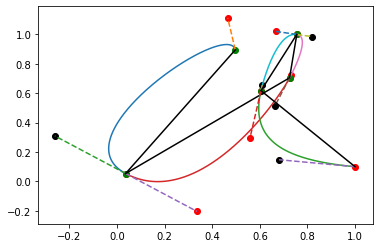

[-0.46048632  0.68844986  0.03039515 -0.15045595  0.39513677]
[-0.841637    0.65124553  0.29537368 -0.38256228 -0.5177936 ]
[0.22703905 0.41705114 0.07196045 0.21934499 0.5003655 ]
[0.40846097 0.21104622 0.2221551  0.10231991 0.49567527]
[2.496146   1.4684206  0.20956613 1.4261161  0.79431295]
[1.3606496  0.5018039  1.4433264  0.23248303 0.7705905 ]
[1, 1, 1, 1, 0]


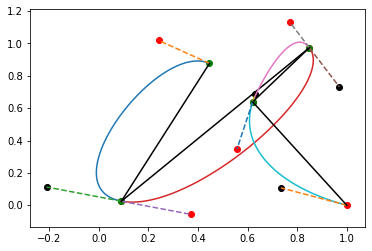

[-0.35539567  0.7582734  -0.22877699  0.3798561 ]
[-0.8511706   0.9481605  -0.33444816 -0.638796  ]
[0.27115554 0.24101014 0.43912646 0.3996309 ]
[0.34092647 0.22243407 0.12270881 0.3854579 ]
[1.7804568  1.1789869  2.0780165  0.74997437]
[1.6835625 1.1382105 0.3865603 0.6501691]
[1, 1, 1, 0]


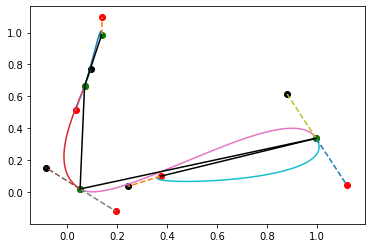

[-0.06865671 -0.01791044  0.9462687  -0.6238806 ]
[-0.32367146 -0.64371985  0.31763285 -0.23792271]
[0.3333333  0.24183917 0.20057173 0.47790247]
[0.3333334  0.29917935 0.30097246 0.2202554 ]
[2.9324424  0.20404436 1.0964365  1.6038454 ]
[0.02396293 0.82603705 1.4972639  3.0538259 ]
[1, 1, 1, 0]


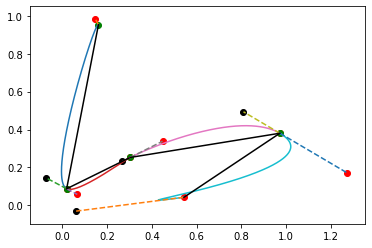

[-0.14219114  0.28438228  0.66899765 -0.4289044 ]
[-0.86512756  0.16524908  0.12758204 -0.33778858]
[0.03959386 0.17104706 0.24634297 0.6719647 ]
[0.12626378 0.12430979 0.2909121  0.8930002 ]
[2.550176   1.0853912  0.34556705 1.8671061 ]
[1.1747322  0.01436418 0.79582554 2.6246707 ]
[1, 1, 1, 0]


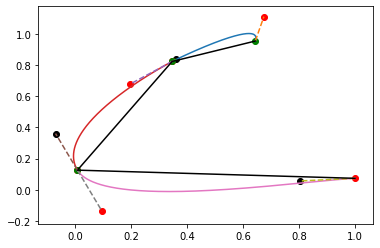

[-0.2972973  -0.33873874  0.9927928 ]
[-0.13089007 -0.6963351  -0.05235601]
[0.48965397 0.26948252 0.27930015]
[0.06389703 0.31901675 0.19778845]
[2.1796894  0.35109454 1.19574   ]
[0.35263446 0.77513236 0.13797978]
[1, 1, 0]


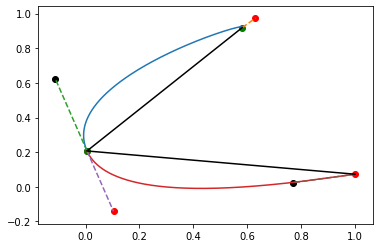

[-0.5758123   0.99458486]
[-0.71215355 -0.13432835]
[0.08054536 0.36083594]
[0.4717428  0.23311186]
[3.0904288 1.1615117]
[0.9549733  0.34350795]
[1, 0]


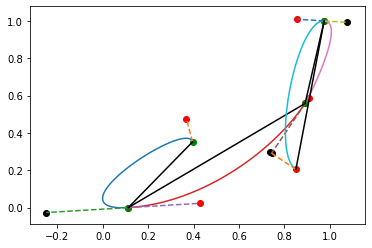

[-0.28291318  0.7787115   0.08403361 -0.12464988]
[-0.35200974  0.55785626  0.44214374 -0.79537153]
[0.27927375 0.33049658 0.07304469 0.15042083]
[0.8027193  0.31749862 0.22237024 0.18198304]
[2.2522318  0.54853773 0.31801686 1.4908217 ]
[2.3208938 0.4435356 1.6831337 1.0444248]
[1, 1, 1, 0]


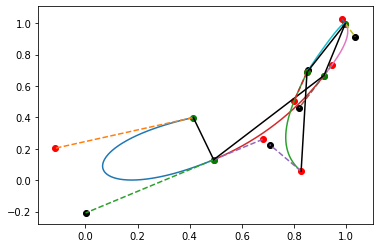

[ 0.07824934  0.4230769   0.08222812 -0.14721483 -0.02254641]
[-0.26865673  0.5360697   0.33084577 -0.3097015  -0.63059705]
[2.0252051  0.3344809  0.22505388 0.089764   0.29734424]
[2.1344063  0.33089504 0.26736748 0.04693625 0.3302955 ]
[1.5003295  0.29854622 0.18925501 2.2739887  0.23046511]
[1.8915118  0.23550178 0.6674381  0.17856818 0.6537363 ]
[1, 1, 1, 1, 0]


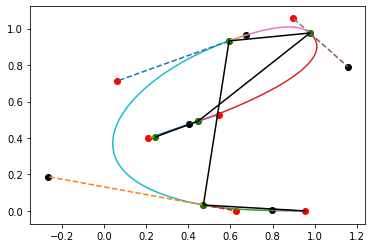

[ 0.2030457   0.53045684 -0.38324875 -0.12182739  0.4822335 ]
[ 0.08648649  0.4837838  -0.04324329 -0.9        -0.03243243]
[0.16002887 0.144649   0.29943037 0.633695   0.3257079 ]
[0.198079   0.36067396 0.22128464 0.83126163 0.32431778]
[2.856254   0.3834336  0.91165024 1.0436372  0.14115952]
[0.04882925 1.6029048  0.2803617  1.497122   0.04967451]
[1, 1, 1, 1, 0]


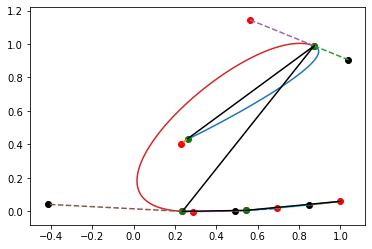

[ 0.61165047 -0.6366158   0.30513173  0.45908463]
[ 0.55514014 -0.988785    0.00560748  0.05420561]
[0.05515952 0.29517975 0.17229602 0.33204395]
[0.2251749  0.55601454 0.15967941 0.33197796]
[3.1290047  1.4640692  0.08354828 0.04184082]
[1.9392838  2.0783992  0.05880467 0.02731981]
[1, 1, 1, 0]


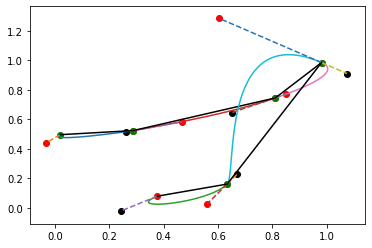

[ 0.26916525  0.52299833  0.17035776 -0.34752983 -0.2572402 ]
[ 0.02782071  0.2210201   0.23956722 -0.82302934 -0.08191654]
[0.27865562 0.3308949  0.16392654 0.5410904  0.5802976 ]
[0.10999682 0.33245412 0.40677088 0.08373494 0.62191486]
[2.4307318  0.0855619  0.39676207 1.8422341  0.7588378 ]
[0.21197028 0.15628172 1.5179553  0.1042919  2.8072832 ]
[1, 1, 1, 1, 0]


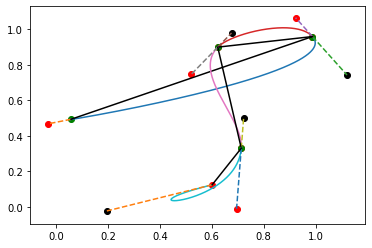

[ 0.9307876  -0.36515516  0.0906921  -0.11217183]
[ 0.4663428  -0.05968076 -0.5697433  -0.20610687]
[0.08990094 0.3367034  0.3185534  1.4568201 ]
[0.24430023 0.2593572  0.295815   1.8410212 ]
[2.9600418  1.1820663  0.74575377 0.4453047 ]
[1.6570789  0.8209282  0.21103622 2.417814  ]
[1, 1, 1, 0]


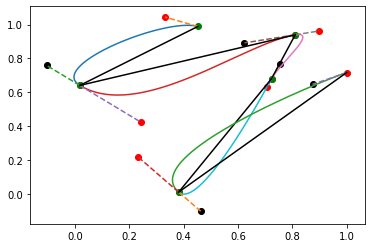

[-0.43383583  0.7922948  -0.08710217 -0.34170854  0.61809045]
[-0.3474903   0.29858428 -0.25868726 -0.66924065  0.70527667]
[0.23654385 0.36767805 0.33333337 0.06908803 0.27497748]
[0.3064679  0.22763969 0.33333337 0.18453458 0.15324204]
[1.107308   1.1281719  2.1462777  0.14494899 1.3431439 ]
[1.6984882  0.10973389 0.00931008 2.0459712  0.342496  ]
[1, 1, 1, 1, 0]


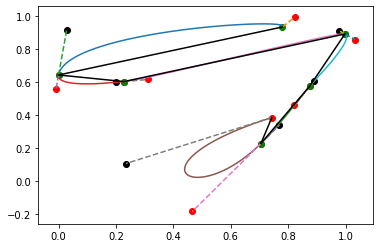

[-0.7796935   0.22796935  0.77011496 -0.12260538 -0.17049807  0.03831416]
[-0.2905882  -0.04000002  0.2882353  -0.31529415 -0.34823525  0.15764706]
[0.08967843 0.3725098  0.10306928 0.14458588 0.33230668 2.9323967 ]
[0.32761422 0.12886962 0.03391074 0.10590439 0.3327112  3.5768623 ]
[2.553983   1.5001272  0.20729274 1.1824038  0.02342547 2.853892  ]
[1.1110283  0.32503518 1.117441   0.06319308 0.07105519 0.83083904]
[1, 1, 1, 1, 1, 0]


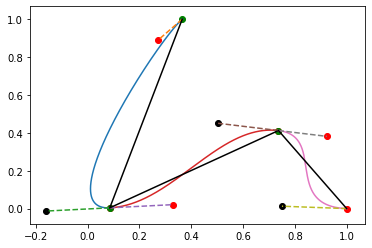

[-0.27959183  0.6510204   0.2632653 ]
[-0.99597317  0.40805367 -0.41208053]
[0.13914037 0.31652737 0.38737977]
[0.2377413  0.30717734 0.51156497]
[0.4277278  0.49077278 0.8393248 ]
[1.9135964  0.7228634  0.95174134]
[1, 1, 0]


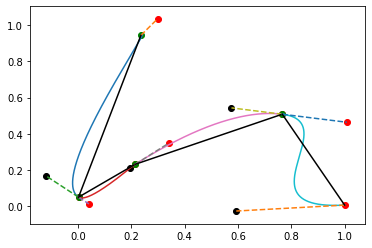

[-0.23392858  0.2125      0.5517857   0.23392856]
[-0.89409983  0.18154311  0.27685326 -0.5022693 ]
[0.12063582 0.19361432 0.28039443 0.4436725 ]
[0.1824743  0.09991406 0.3137321  0.7358936 ]
[2.7979915  1.4734143  0.28213596 0.9533931 ]
[1.0602889  0.04321986 0.6465901  1.2154408 ]
[1, 1, 1, 0]


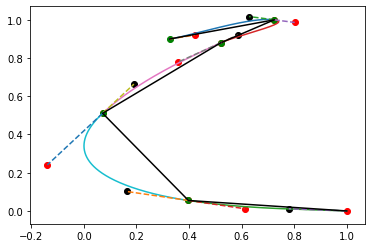

[ 0.3979592  -0.20408165 -0.4489796   0.3265306   0.6020408 ]
[ 0.10036498 -0.12043798 -0.36861312 -0.45620435 -0.05474453]
[0.23830949 0.33333346 0.32869172 0.60992706 0.36382672]
[0.23707007 0.33333328 0.3328721  0.42842954 0.36491954]
[0.03634762 2.4314263  0.131295   1.283146   0.10748447]
[0.42406458 0.02525534 0.22149706 0.7514852  0.03899922]
[1, 1, 1, 1, 0]


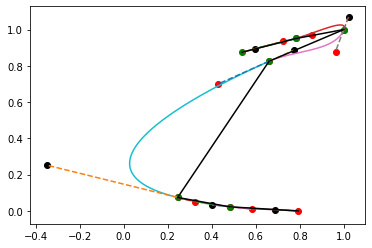

[ 0.24528307  0.21698111 -0.33962262 -0.41509438  0.23584907  0.31132072]
[ 0.07604563  0.04942966 -0.17490494 -0.7509506  -0.0513308  -0.02281369]
[0.7690475  0.33333337 0.33333325 0.3100936  0.33333328 0.33333343]
[0.7652088  0.3333335  0.33333334 0.71954536 0.3333333  0.3333334 ]
[0.01542424 0.06705023 0.7945094  0.5684016  0.07776273 0.06203257]
[0.0122503  2.0954776  0.02278475 1.7843546  0.08025744 0.00786152]
[1, 1, 1, 1, 1, 0]


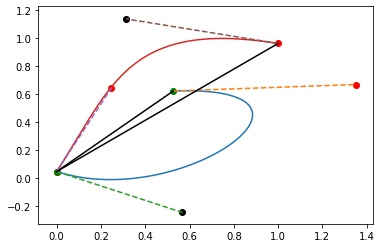

[-0.527027  1.      ]
[-0.5773109   0.91764706]
[1.0575757  0.47745708]
[0.8175025 0.5221071]
[2.3666     0.43683648]
[1.3077497 0.9935791]
[0, 0]


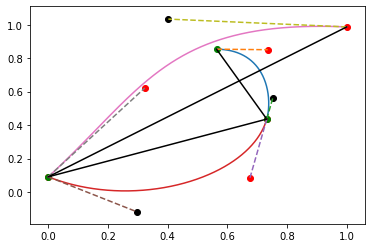

[ 0.16836733 -0.73214287  1.        ]
[-0.41778973 -0.3450135   0.89577717]
[0.38077533 0.4386362  0.46314344]
[0.28017068 0.4479826  0.44645315]
[1.1681527 0.9716084 0.2930387]
[0.54193115 1.0540508  0.808586  ]
[1, 0, 0]


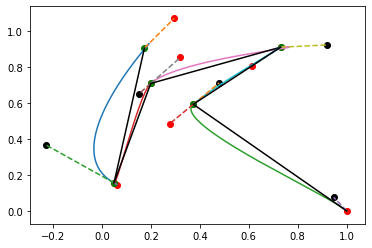

[-0.12441314  0.15023473  0.5305164  -0.3568075   0.6267606 ]
[-0.75084174  0.55387205  0.20202017 -0.3181818  -0.5942761 ]
[0.26981443 0.03061482 0.33333337 0.33333334 0.16826022]
[0.45774955 0.13222645 0.33333334 0.33333337 0.10792419]
[2.6726837  1.9553483  0.5102934  0.00514273 1.5383911 ]
[1.085541   0.43185318 2.8428226  0.11627699 0.20322368]
[1, 1, 0, 1, 0]


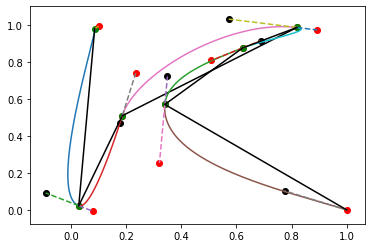

[-0.05789474  0.15789473  0.6333333  -0.19649124 -0.28245616  0.65964913]
[-0.9568      0.48640004  0.47679996 -0.11040002 -0.3056     -0.5696    ]
[0.02121272 0.1138831  0.2960446  0.33333343 0.3174495  0.36322677]
[0.14482233 0.07872164 0.31699282 0.33333316 0.36531803 0.28409156]
[2.3705842  1.7794874  0.71717924 2.449208   0.28822175 0.9202215 ]
[1.1086495  0.10603835 0.8257345  0.02696086 0.6843854  0.284457  ]
[1, 1, 1, 1, 1, 0]


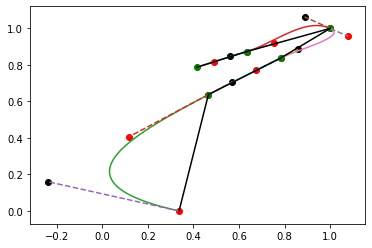

[ 0.21782178  0.36633664 -0.21782178 -0.31683168 -0.12871289]
[ 0.08551723  0.12689656 -0.16275865 -0.19999999 -0.63724136]
[0.33333328 0.3333333  0.33333334 0.33333334 0.64609104]
[0.33333316 0.33333334 0.33333337 0.3333333  0.9204859 ]
[0.01045758 0.01858413 1.9914758  0.00821088 0.7861903 ]
[0.02542696 0.84186125 0.08408798 0.02316582 1.4983703 ]
[1, 1, 1, 1, 0]


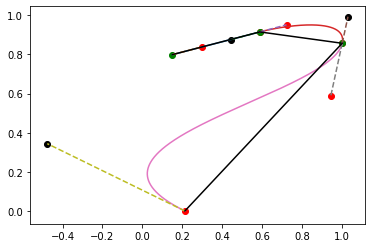

[ 0.43749997  0.41250002 -0.7875    ]
[ 0.11608618 -0.05804306 -0.8573798 ]
[0.33333337 0.33333328 0.23551777]
[0.3333333  0.33333328 0.66127455]
[0.00539134 0.40548792 0.5337287 ]
[0.0082932 1.6402193 1.8505182]
[1, 1, 0]


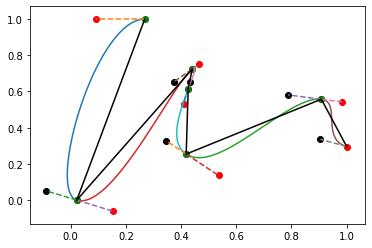

[-0.2463557   0.41836733 -0.01457724 -0.00728863  0.4897959   0.09183675]
[-1.          0.7237164  -0.10757947 -0.3618582   0.3031785  -0.2616137 ]
[0.1731997  0.17160843 0.33333337 0.23502444 0.28932086 0.2712282 ]
[0.11924458 0.11620169 0.3333334  0.2856052  0.21305464 0.3721224 ]
[1.3292519  1.4826521  2.5140963  0.17930225 1.3428345  1.0384021 ]
[1.3763413  0.23773049 0.06840261 0.8023951  0.74910206 0.8361816 ]
[1, 1, 1, 1, 1, 0]


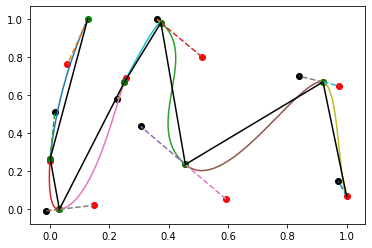

[-0.12634088  0.03098927  0.2193087   0.12276518  0.08224076  0.4636472
  0.07985699]
[-0.73384035 -0.26615968  0.6692015   0.31178713 -0.7452472   0.43346006
 -0.60076046]
[0.33166316 0.05509219 0.16665588 0.06098577 0.29988313 0.35693714
 0.09612107]
[0.33195007 0.17543797 0.13214058 0.06781594 0.33371946 0.1358052
 0.14148067]
[0.10936506 0.18088399 1.0686191  0.10475565 0.54392415 1.6775701
 1.0696895 ]
[0.10695562 1.640378   0.04527985 2.1125858  0.5350871  1.1207404
 0.20309961]
[1, 1, 1, 1, 1, 1, 0]


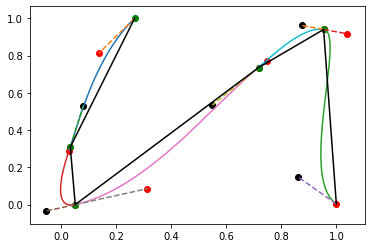

[-0.23393317  0.01799486  0.66580975  0.23650384  0.04627252]
[-0.6912752  -0.30872482  0.73489934  0.20469797 -0.9362416 ]
[0.31338722 0.06291695 0.27823183 0.15877992 0.09309832]
[0.3102072  0.36095467 0.26380345 0.26522756 0.21732756]
[0.27979553 0.26800612 0.5192438  0.16265635 1.2576339 ]
[0.11718366 1.8280123  0.04110438 0.9772423  0.7143561 ]
[1, 1, 1, 1, 0]


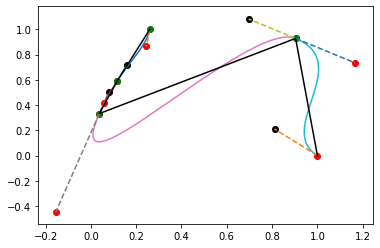

[-0.14438502 -0.07843138  0.8663102   0.09625667]
[-0.4099723  -0.2576177   0.5955679  -0.92797786]
[0.3137514 0.6843623 0.7655907 0.3521549]
[0.3118576  0.6547838  0.24487317 0.30298787]
[0.22222231 0.02993437 2.415146   0.83036643]
[0.01500502 0.05384481 1.2393477  0.62995523]
[1, 1, 1, 0]


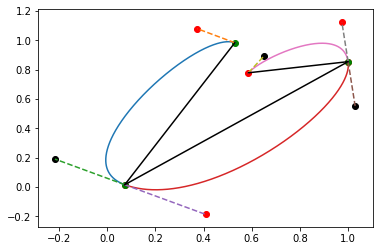

[-0.45698923  0.92741936 -0.41397852]
[-0.96699667  0.83828384 -0.07590759]
[0.17078596 0.3140244  0.64253753]
[0.3163633  0.24202374 0.3127529 ]
[1.6798693 1.2770536 1.655804 ]
[1.4701799  0.93217725 0.8760154 ]
[1, 1, 0]


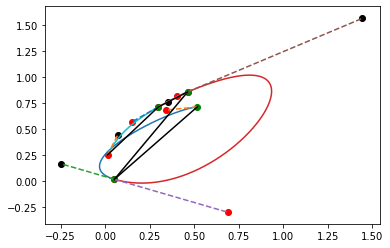

[-0.46555823  0.41092637 -0.16389549 -0.28503564]
[-0.696477    0.8401084  -0.1436314  -0.46070462]
[0.21193016 0.7612453  0.33333337 0.37601182]
[0.39962852 1.2932991  0.33333325 0.37117875]
[0.8033349  1.5778099  0.09527578 0.24580292]
[1.6980988  2.6506999  0.05259224 0.2650358 ]
[1, 1, 1, 0]


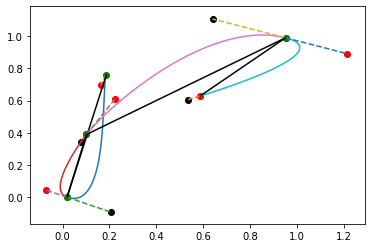

[-0.16763005  0.08285163  0.849711   -0.36416185]
[-0.7596048   0.38968167  0.6004391  -0.36114162]
[0.08538997 0.25408754 0.24251701 0.5475251 ]
[0.26694125 0.13147347 0.3197172  0.11028359]
[0.14746337 1.3203404  0.45108342 2.001158  ]
[1.8135518 0.2952163 0.974367  2.7732956]
[1, 1, 1, 0]


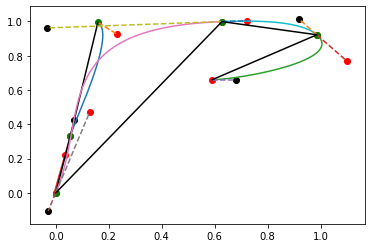

[-0.10433386 -0.05457464  0.62760836  0.35794544 -0.3948636 ]
[-0.66469896 -0.3293979   0.99881935 -0.07674146 -0.26210153]
[0.14767446 0.3333333  0.41489127 0.26077402 0.40329668]
[0.14089888 0.3333333  0.5609803  0.3082975  0.19077696]
[0.96900886 0.00748498 0.2955193  0.26687276 1.6214815 ]
[0.01145014 3.0400257  0.9542209  0.7229413  0.58603483]
[1, 1, 1, 1, 0]


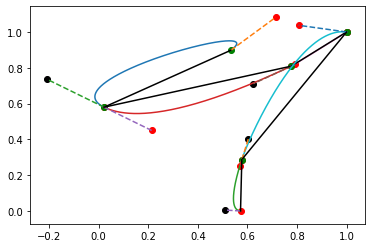

[-0.5110821   0.7548892   0.22294652 -0.42242503 -0.00521511]
[-0.31812721  0.22929168  0.19087636 -0.71308523 -0.28691477]
[0.42960516 0.29389924 0.05951651 0.2375738  0.12227133]
[0.46109354 0.2296867  0.00125526 0.14395797 0.22109775]
[2.9041703  0.8910142  0.1408064  1.2274649  0.20707704]
[1.9886973  0.27377138 2.2348483  0.3100588  1.5123935 ]
[1, 1, 1, 1, 0]


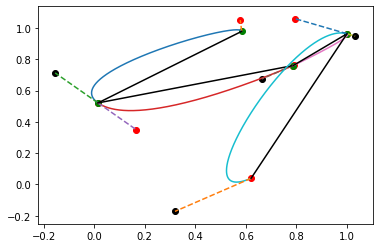

[-0.56845236  0.7723214   0.21279764 -0.37946427]
[-0.45721585  0.23882502  0.20306516 -0.9233717 ]
[0.09907048 0.28308937 0.01800869 0.22681734]
[0.3507504  0.18712008 0.12042058 0.36884877]
[2.1706283 1.14642   0.1642519 1.6187094]
[1.6177101 0.3017923 1.9417286 2.5729039]
[1, 1, 1, 0]


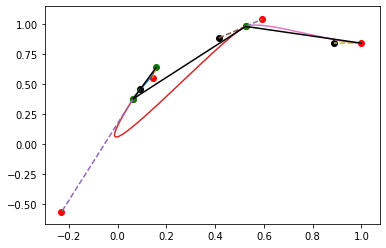

[-0.09423077  0.46153843  0.47500002]
[-0.26086956  0.60302454 -0.13988656]
[0.32063544 1.303005   0.18498652]
[0.3235484  0.19529355 0.2258916 ]
[0.17890358 2.790868   1.0077966 ]
[0.04498857 0.1961927  0.2864629 ]
[1, 1, 0]


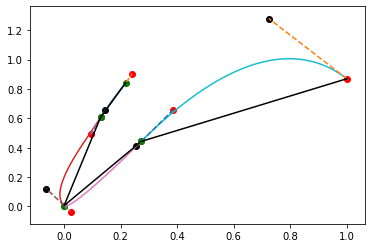

[-0.08971962 -0.12897196  0.27289718  0.7271028 ]
[-0.23697919 -0.6015625   0.4375      0.42708334]
[0.2517932  0.19536597 0.09463823 0.28711227]
[0.19793545 0.21534996 0.07362959 0.5859071 ]
[3.120975   0.07823469 2.0834284  0.5556453 ]
[0.07373396 0.71164316 0.07432602 1.5095786 ]
[1, 1, 1, 0]


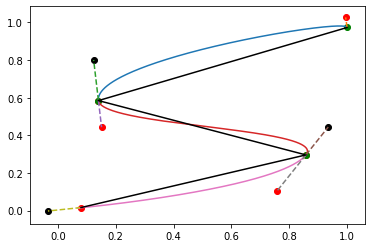

[-0.8599034  0.7173913 -0.7777778]
[-0.38859177 -0.28877008 -0.2798574 ]
[0.05723646 0.18335906 0.26465756]
[0.22974591 0.2159065  0.13977273]
[1.8987324  1.1115648  0.74496025]
[1.2229161 1.6685606 2.9552166]
[1, 1, 0]


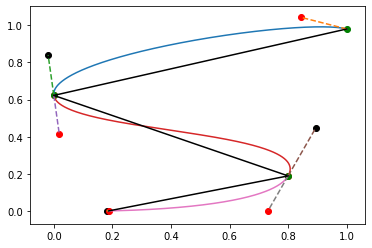

[-1.         0.8       -0.6130435]
[-0.35797668 -0.43385214 -0.18871595]
[0.15897809 0.22876088 0.30996066]
[0.20409127 0.30154696 0.00957064]
[0.72662234 0.9847214  0.9223201 ]
[1.3161886 1.4237262 2.5671413]
[1, 1, 0]


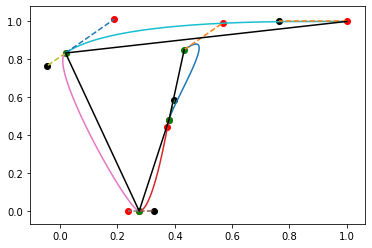

[-0.05285716 -0.10428572 -0.25714284  0.98142856]
[-0.36856368 -0.48238483  0.8333333   0.16666669]
[0.5288624  0.08460289 0.04486357 0.2478867 ]
[0.28716967 0.10161124 0.10812028 0.23580725]
[2.5222187  0.04019633 1.2715036  0.64129466]
[0.03228289 1.3578938  1.0605999  0.16824107]
[1, 1, 1, 0]


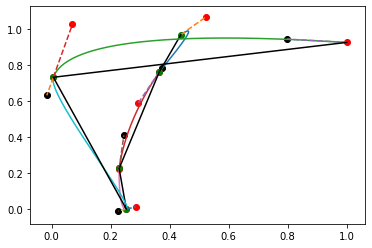

[-0.07328242 -0.13587788  0.02442747 -0.24732824  0.99389315]
[-0.20731705 -0.535061   -0.22560975  0.73170733  0.19359756]
[0.5937625  0.33312765 0.01263969 0.04543036 0.2967654 ]
[0.11829337 0.33380234 0.12841225 0.1328789  0.20118187]
[2.7718954  0.14425616 0.20268187 1.5300932  1.1612252 ]
[0.05630158 0.16153906 1.8295662  0.5431738  0.2829171 ]
[1, 1, 1, 1, 0]


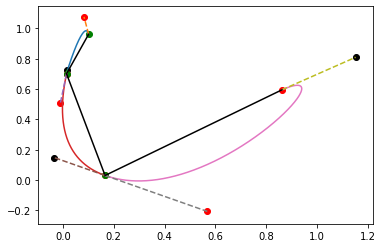

[-0.08704453  0.15182187  0.6963563 ]
[-0.26086956 -0.6711956   0.5652174 ]
[0.4213369  0.28316194 0.5209209 ]
[0.10108872 0.33853066 0.40227   ]
[2.6611838  0.34747097 1.2143687 ]
[0.1977105  0.81580323 3.0971797 ]
[1, 1, 0]


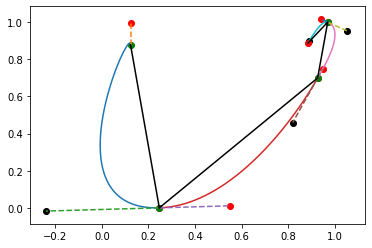

[ 0.12345679  0.6790123   0.04320991 -0.08436215]
[-0.87762237  0.6993007   0.3006993  -0.11188811]
[0.13439706 0.30978468 0.17927262 0.22846204]
[0.54942584 0.26937675 0.3098323  0.06161296]
[3.0017705  0.7643609  0.27686042 1.4401519 ]
[1.4668012  0.35132134 1.198158   0.17526807]
[1, 1, 1, 0]


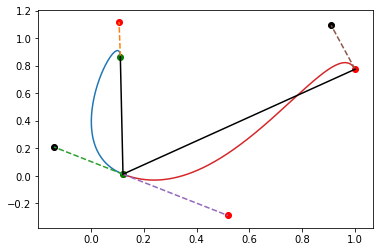

[0.01012658 0.87848103]
[-0.8535032   0.76114655]
[0.29233605 0.42804745]
[0.38347906 0.2846546 ]
[3.1338892 1.36051  ]
[0.91238356 2.0081265 ]
[1, 0]


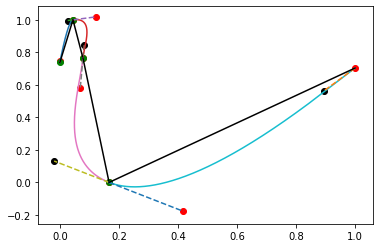

[0.04427083 0.03385417 0.08854167 0.8333333 ]
[ 0.2616279  -0.23546511 -0.7645349   0.70348835]
[0.0315345  0.3333333  0.23967078 0.2827106 ]
[0.06881332 0.33333322 0.29604742 0.15978591]
[0.0572344 1.6564914 0.1650671 1.3159964]
[1.1747596  0.19279625 0.8406175  0.2253493 ]
[1, 1, 1, 0]


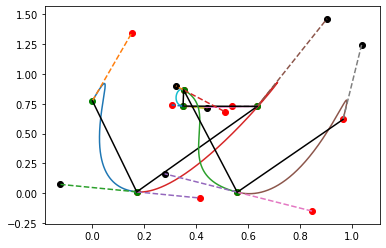

[ 0.17094018  0.4639805  -0.2857143   0.002442    0.20634922  0.40781438]
[-0.76363635  0.7168831   0.00259739  0.1350649  -0.8571428   0.6103896 ]
[0.74987054 0.291308   0.3333333  0.33333328 0.2752225  0.4483525 ]
[0.38396972 0.9163882  0.33333325 0.33333322 0.36265442 0.8571928 ]
[2.661032   1.2059832  0.00857273 1.3767291  0.4814676  1.4857934 ]
[1.1409757  2.917692   0.20326488 2.4056287  0.8305485  2.66605   ]
[1, 0, 1, 1, 1, 0]


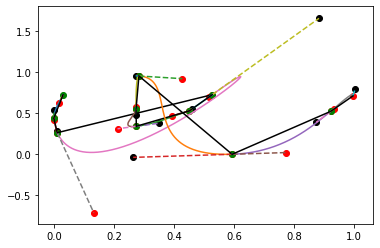

[-0.03076923  0.01153846  0.51634616 -0.07596153 -0.17692307 -0.00096154
  0.00961539  0.31057692  0.32884616  0.07403845]
[-0.2836364  -0.17636365  0.46181822 -0.19636369 -0.1872727   0.20909092
  0.40181816 -0.9509091   0.52181816  0.18727273]
[0.33372247 0.10643356 1.4144452  0.13503791 0.33333337 0.3333333
 0.06609733 0.1478716  0.29477498 0.15630628]
[0.33717194 0.10130064 1.4338309  0.11973109 0.33333328 0.3333334
 0.02853197 0.33182177 0.23015465 0.40780872]
[0.0331733  0.075367   2.1760492  0.01848472 0.00950763 2.020147
 0.03153149 1.0319796  0.89437574 0.03344705]
[0.10247231 0.06424073 2.6668563  0.01941942 0.35994592 0.01171449
 1.7699579  1.3692118  0.21422707 2.8482091 ]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


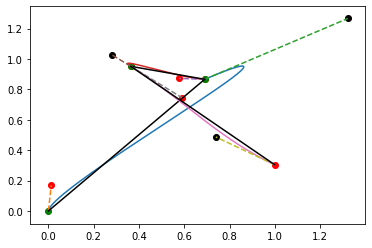

[ 0.6903553  -0.32656512  0.63620985]
[ 0.8666667   0.08518517 -0.6481482 ]
[0.15317588 0.3333333  0.33606935]
[0.6753505  0.3333334  0.35068586]
[0.59665453 0.20210154 0.05533215]
[2.8082123  2.6572826  0.18159236]
[0, 1, 0]


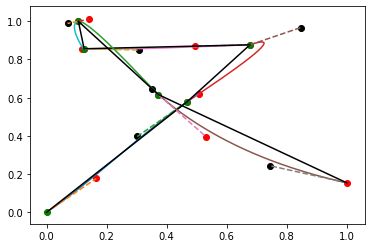

[ 0.46833014  0.20921302 -0.5527831  -0.01919386  0.26679462  0.6276392 ]
[ 0.5790554   0.2977413  -0.02053386  0.14373714 -0.38398355 -0.46201235]
[0.32466054 0.15677205 0.33333334 0.04350564 0.08083713 0.34826574]
[0.33156875 0.52728033 0.33333328 0.26100558 0.07830722 0.34676486]
[0.07168426 0.12781413 0.0044116  1.398367   1.2602258  0.3115203 ]
[0.05996916 2.6744633  0.07712664 1.4069326  0.02057178 0.29778582]
[1, 0, 1, 1, 1, 0]


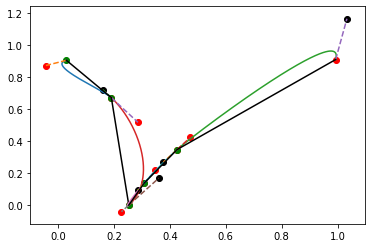

[0.16090426 0.06250001 0.05452126 0.11835107 0.5678191 ]
[-0.23338735 -0.6709887   0.13614263  0.21069692  0.56239873]
[0.2830746  0.2688822  0.33333328 0.37217024 0.11216889]
[0.20996383 0.29458573 0.33333328 0.38143566 0.32296175]
[1.7571976  0.4607046  2.95377    0.03915022 0.23350191]
[0.05119931 0.6608879  0.09440556 0.04594653 2.507887  ]
[1, 1, 1, 1, 0]


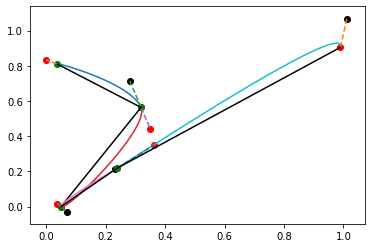

[ 0.2822695  -0.26950353  0.19007091  0.75035465]
[-0.24661243 -0.56368566  0.2195122   0.6856369 ]
[0.11756025 0.19798024 0.0733492  0.17572327]
[0.41591242 0.05621891 0.03423691 0.1607406 ]
[2.9901943  0.6945232  1.3229777  0.07721356]
[0.60421526 2.0862882  0.04759062 2.4412603 ]
[1, 1, 1, 0]


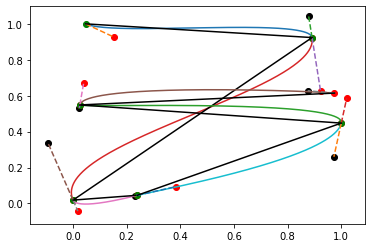

[ 0.8439202  -0.8911071   0.23956443  0.7604356  -0.9745917   0.94918334]
[-0.07628864 -0.90515465  0.02680412  0.40206185  0.10103095  0.06597936]
[0.14994252 0.23516439 0.26388544 0.17565368 0.14265108 0.13164608]
[0.139548   0.2631657  0.04478321 0.22050221 0.01687643 0.10592645]
[0.5200043  0.8838714  1.396835   0.16435178 1.613164   1.3845699 ]
[1.374354   1.0629755  0.21242334 0.9387738  1.5843276  0.1997946 ]
[1, 1, 1, 1, 1, 0]


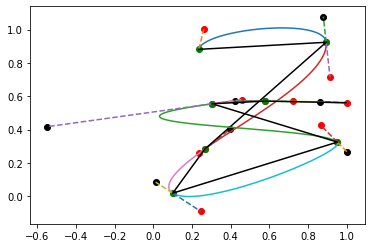

[ 0.65895957 -0.62813103 -0.16570328  0.8516378  -0.6473988   0.2755299
  0.42003852]
[ 0.04233873 -0.641129   -0.2641129   0.3064516   0.22983873  0.01612902
 -0.01008064]
[0.18632244 0.23268224 0.11923137 0.19872308 0.19231655 0.5636202
 0.33371451]
[0.23478816 0.19763832 0.35390973 0.08485466 1.2582935  0.56346506
 0.33372736]
[1.2973721  0.8704414  0.27072892 0.9897109  0.52327615 0.10136814
 0.01152595]
[1.5396804  0.05569242 1.4868243  1.9317795  2.64084    0.07283541
 0.02289133]
[1, 1, 1, 1, 1, 1, 0]


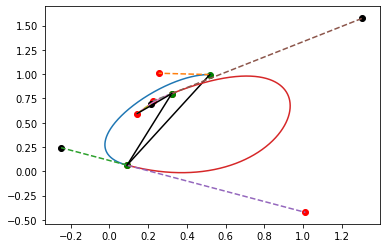

[-0.42694062  0.23059359 -0.17808218]
[-0.93208826  0.7368421  -0.20543295]
[0.2581358  1.3471234  0.45960385]
[0.37537864 1.6178732  0.44364992]
[1.1943388  1.7535887  0.18893379]
[1.5142365  2.541902   0.10083739]
[1, 1, 0]


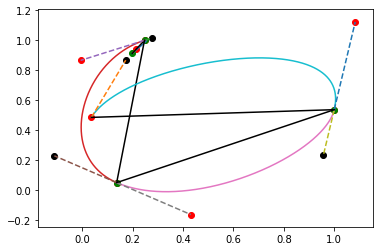

[ 0.04884319 -0.11053985  0.8637532  -0.9640103 ]
[ 0.08732879 -0.94863015  0.48630133 -0.05136985]
[0.33333334 0.30018988 0.36670032 0.6118466 ]
[0.3333335  0.31949595 0.3111529  0.41946304]
[0.02447434 0.96952784 1.1388985  1.7655388 ]
[2.565561  1.0606803 0.9165168 1.1742648]
[1, 1, 1, 0]


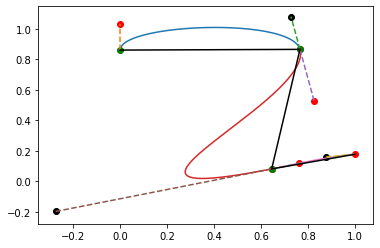

[ 0.76545167 -0.12044376  0.3549921 ]
[ 0.00467288 -0.78504676  0.0965732 ]
[0.22693981 0.43445644 0.33603242]
[0.2851478  1.2105012  0.33736384]
[1.5646917  0.32845005 0.02982434]
[1.4006978  2.0177252  0.12293841]
[1, 1, 0]


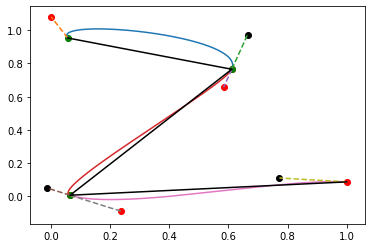

[ 0.5546493  -0.5464927   0.93474716]
[-0.18856263 -0.7588872   0.08037094]
[0.23724851 0.11988652 0.20915572]
[0.36650607 0.09455092 0.24352758]
[2.3128147  0.37394902 0.5961576 ]
[1.4932677  1.6845202  0.18878727]
[1, 1, 0]


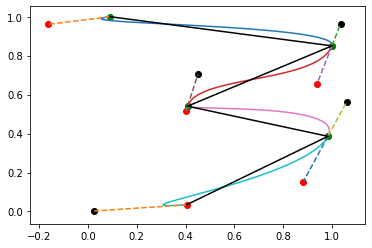

[ 0.90927833 -0.5917526   0.5752577  -0.5793814 ]
[-0.14974618 -0.3096447  -0.15482232 -0.35152283]
[0.28117114 0.3052627  0.04461817 0.37384915]
[0.12951614 0.25181532 0.3250683  0.5604777 ]
[2.825684  0.7848782 1.562221  0.6166078]
[1.7114111  0.83438736 1.716739   2.6809292 ]
[1, 1, 1, 0]


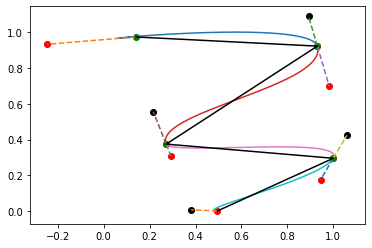

[ 0.7917448 -0.6585366  0.727955  -0.5046904]
[-0.05139506 -0.5491923  -0.07929516 -0.29515418]
[0.48769826 0.2657096  0.09452789 0.22724196]
[0.2149976  0.22212216 0.19245496 0.1948243 ]
[2.9704247 1.1017424 1.1619364 0.6105223]
[1.2799251 1.1760591 1.8934002 2.5602543]
[1, 1, 1, 0]


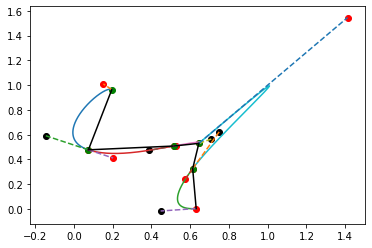

[-0.12066574  0.4410541   0.12898749 -0.03190011  0.01803046]
[-0.48590606  0.03087246  0.02147651 -0.20402682 -0.32214764]
[0.12610658 0.32504085 0.07363264 6.1634846  0.27657533]
[0.4942539  0.2997836  0.5586901  1.5823957  0.57212603]
[2.1440284  0.547092   0.11081461 2.6494951  0.48776752]
[1.3370225  0.19861847 2.8077595  0.27674615 1.6220043 ]
[1, 1, 0, 1, 0]


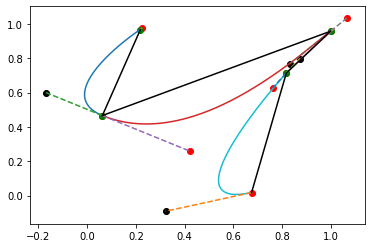

[-0.15625     0.9375     -0.18154764 -0.14285713]
[-0.5007924   0.49128368 -0.24405706 -0.6957211 ]
[0.02251814 0.39292958 0.3333332  0.14369635]
[0.5110413  0.24071312 0.33333343 0.51987094]
[2.8841007 1.0059252 3.0587862 0.3763698]
[1.3499995  0.36613217 0.06124302 2.0723543 ]
[1, 1, 1, 0]


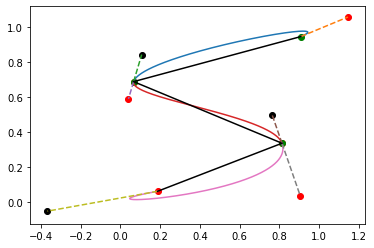

[-0.8404453   0.7458256  -0.62523186]
[-0.25721782 -0.35170606 -0.2742782 ]
[0.29799888 0.12338833 0.45835504]
[0.18182307 0.20322213 0.8274969 ]
[2.9979172 1.3873501 1.4540461]
[1.0166088 0.8335085 2.9301457]
[1, 1, 0]


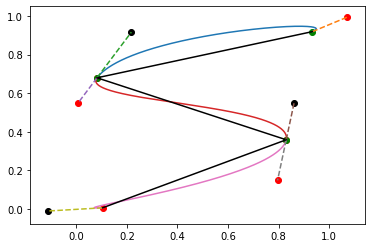

[-0.8524229   0.7488987  -0.72687227]
[-0.23974764 -0.32176653 -0.3533123 ]
[0.17881219 0.18630953 0.2646154 ]
[0.30864733 0.23788361 0.26808912]
[2.9162807 1.6857362 0.9568536]
[0.77588326 1.3264961  2.7657084 ]
[1, 1, 0]


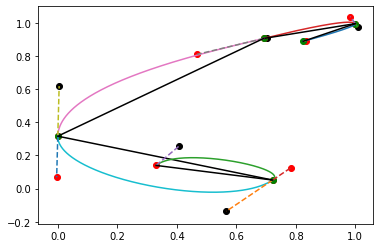

[ 0.17500001 -0.30833334 -0.69166666  0.7222222  -0.39166665]
[ 0.10629368 -0.08951044 -0.5888112  -0.26433566  0.08811188]
[0.05062911 0.14342952 0.2673635  0.3223139  0.24300411]
[0.10077216 0.03933436 0.3321711  0.31739825 0.34787574]
[0.10173695 1.4752305  0.3006286  1.2352148  2.0408144 ]
[1.4031107  0.12408454 0.8502784  1.2303444  1.2072955 ]
[1, 1, 1, 1, 0]


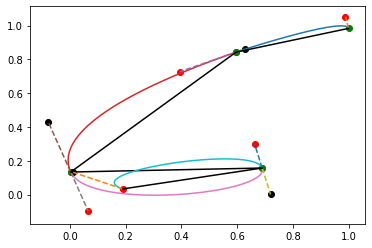

[-0.40384614 -0.59375     0.6875     -0.5       ]
[-0.14043999 -0.7089678   0.02368866 -0.12351946]
[0.16452907 0.25157303 0.3489911  0.2778055 ]
[0.08338846 0.33470705 0.23110278 0.3949236 ]
[1.7489028  0.35288802 1.3396246  1.6233108 ]
[0.18641062 0.96280175 1.7260269  2.3984928 ]
[1, 1, 1, 0]


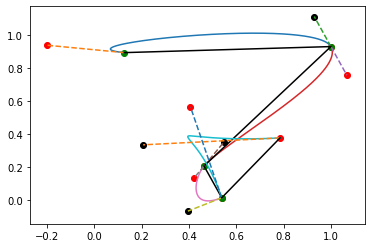

[ 0.8727015  -0.5360679   0.07496464  0.24611032]
[ 0.03650588 -0.7209909  -0.1916558   0.3611473 ]
[0.3750267  0.2063431  0.41274497 1.2892649 ]
[0.2227025  0.18869953 0.7976043  1.3262658 ]
[2.9640458  1.0099897  0.90042955 0.83475053]
[1.2419567  0.11185913 1.7109462  0.9009163 ]
[1, 1, 0, 0]


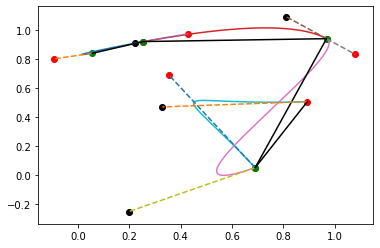

[ 0.19945727  0.71370417 -0.27815467  0.20352781]
[ 0.08068782  0.01984125 -0.8862434   0.45370367]
[0.70956784 0.25711724 0.1674786  1.450525  ]
[0.15198608 0.30501968 0.6203305  1.138365  ]
[3.0080843  0.2679491  1.1097636  0.90725636]
[0.09028213 0.79295766 2.4246752  1.0850677 ]
[1, 1, 0, 0]


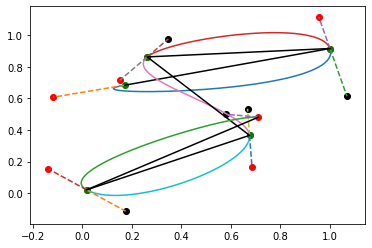

[ 0.82911396 -0.73839664  0.41350213 -0.65822786  0.6940928 ]
[ 0.23206383 -0.0531444  -0.49601418 -0.3445527   0.45969883]
[0.34632856 0.27395266 0.286352   0.268684   0.24500462]
[0.35886505 0.1932959  0.26072773 0.27942252 0.1567186 ]
[3.125058  1.4195774 1.3383281 1.1374676 1.8487482]
[1.520955   0.8555546  0.64603394 1.190106   0.724029  ]
[1, 1, 1, 1, 0]


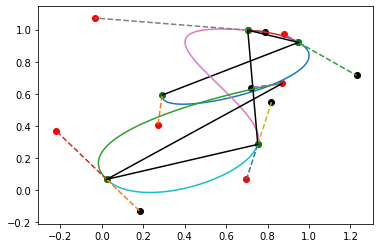

[ 0.6581986  -0.24480373  0.04849887 -0.7297921   0.847575  ]
[ 0.328084    0.07611549 -0.71128607 -0.21784776  0.5971129 ]
[0.25290236 0.33138496 1.0414512  0.29439425 0.37350836]
[0.47257617 0.32292098 0.37982312 0.33490592 0.14851893]
[2.142753   0.33082664 1.7412108  1.0344162  1.6365286 ]
[2.0470364  0.1993469  0.3143929  1.1814152  0.44894361]
[1, 1, 1, 1, 0]


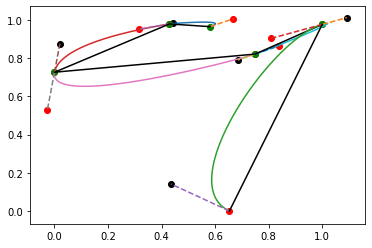

[-0.15151519 -0.42929292  0.74915826  0.25084174 -0.34680134]
[ 0.01425183 -0.25296915  0.09501189  0.15558195 -0.9774347 ]
[0.6350274  0.23748714 0.26619163 0.33333337 0.19706427]
[0.08287086 0.30197865 0.09375093 0.33333343 0.2503963 ]
[2.608076   0.2989056  1.8311354  0.10715918 0.8625147 ]
[0.32895654 0.90412545 0.32223523 2.9535775  1.3377151 ]
[1, 1, 1, 1, 0]


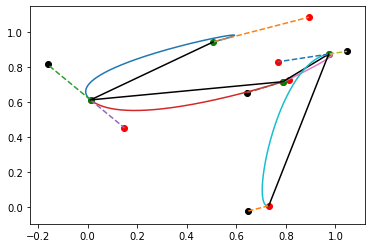

[-0.4954955   0.7762763   0.1846847  -0.24174178]
[-0.33210784  0.10416669  0.1580882  -0.86764705]
[0.68790245 0.26922548 0.10098685 0.2342052 ]
[0.44749546 0.20068207 0.30745125 0.09753989]
[2.9018376  0.99660176 0.2953114  1.0862962 ]
[1.6879027  0.27983817 2.646306   2.1977634 ]
[1, 1, 1, 0]


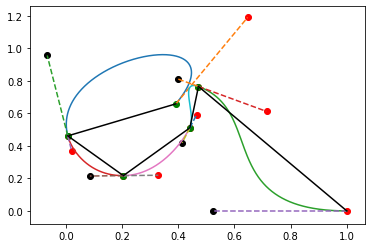

[-0.38502675  0.19786096  0.23663102  0.03074867  0.52807486]
[-0.19723865 -0.24457593  0.2938856   0.25443786 -0.76528597]
[1.3617724  0.30136198 0.3301848  0.33333334 0.30826294]
[1.1555417  0.37930322 0.2526021  0.3333333  0.5113611 ]
[2.4918206  0.53329945 0.8732533  0.1679948  0.40297318]
[1.2443402  0.91028345 0.38996786 2.0143328  0.96679056]
[1, 1, 1, 1, 0]


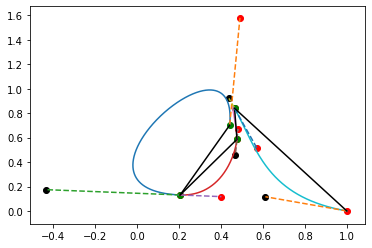

[-0.23636365  0.27107438 -0.01157025  0.5355372 ]
[-0.5714286  0.4552058  0.2542373 -0.8401937]
[1.4220352  0.37258095 0.33333337 0.3445532 ]
[1.0334661  0.24630025 0.33333343 0.4069731 ]
[2.8050494  1.1017275  0.10788626 0.2508314 ]
[1.8949724  0.47515208 2.8702598  0.7122111 ]
[1, 1, 1, 0]


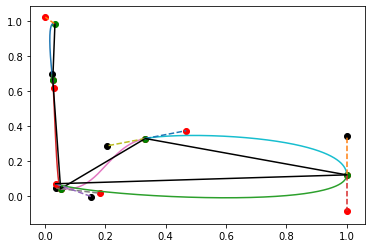

[-0.00707547  0.0259434   0.28066036  0.6674528  -0.9646226 ]
[-0.31846344 -0.6245353   0.28748453 -0.20817843 -0.05080545]
[0.1605106  0.07423846 0.3333333  0.20430121 0.21519388]
[0.09632906 0.02376316 0.33333334 0.317416   0.1439549 ]
[2.4488208  0.04751042 0.99195534 0.6223686  1.5181764 ]
[0.11142734 1.3347715  0.4774281  1.2684603  0.60829836]
[1, 1, 1, 1, 0]


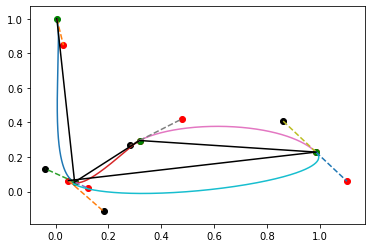

[ 0.06728538  0.24593967  0.6682134  -0.937355  ]
[-0.9454094   0.2406948  -0.06699753 -0.16501242]
[0.1635326  0.18014906 0.29985324 0.21610647]
[0.14180148 0.13659932 0.3246634  0.23269644]
[0.09022787 1.3821008  0.7609963  2.0030482 ]
[0.89228064 0.11410281 0.86436313 1.102816  ]
[1, 1, 1, 0]


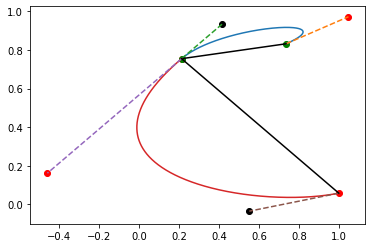

[-0.5231481  0.787037 ]
[-0.07722008 -0.6969112 ]
[0.6474918  0.85266423]
[0.510722   0.43526223]
[2.8660457 1.6934912]
[0.57682484 0.93029   ]
[1, 0]


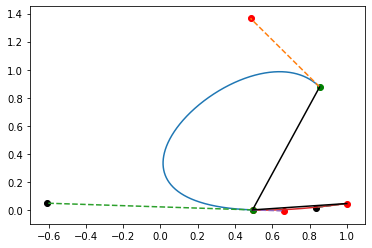

[-0.35999998  0.5058824 ]
[-0.8768898   0.04535637]
[0.6476163 0.3372551]
[1.1647027  0.33535975]
[2.1035235  0.13284415]
[1.9170176  0.08266703]
[1, 0]


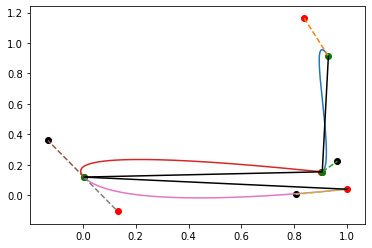

[-0.02325583 -0.9031008   0.996124  ]
[-0.7605119  -0.03473492 -0.07952468]
[0.34993243 0.00632014 0.2575739 ]
[0.11862499 0.3062825  0.19620222]
[2.7577546 0.8430229 0.9750561]
[0.6589544  2.048429   0.25377902]
[1, 1, 0]


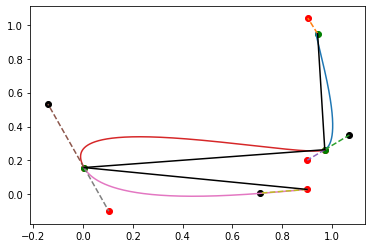

[ 0.02884614 -0.9673077   0.8961538 ]
[-0.6833825  -0.10521141 -0.12881023]
[0.14720792 0.09626926 0.3045533 ]
[0.19230555 0.41241214 0.209312  ]
[2.781727  0.6113686 1.0587212]
[0.89329654 1.8317728  0.2574995 ]
[1, 1, 0]


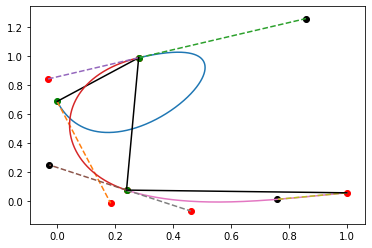

[ 0.28143713 -0.04191618  0.76047903]
[ 0.3006993  -0.9114219  -0.01864802]
[1.7615148  0.37898782 0.34809485]
[1.5488797  0.34806404 0.32185093]
[2.1316504 1.0878305 0.5519606]
[2.7601182  1.0402867  0.20926462]
[1, 1, 0]


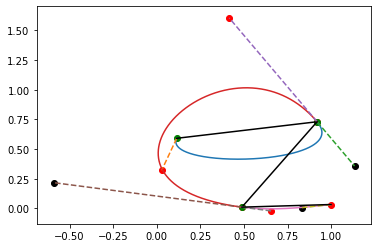

[ 0.8051948  -0.43116882  0.51168835]
[ 0.13938051 -0.7190265   0.02212389]
[0.34652483 1.202139   0.3359665 ]
[0.52667266 1.3106736  0.32958347]
[2.0520716  2.0783036  0.23190235]
[1.9225138  1.9223188  0.11160517]
[1, 1, 0]


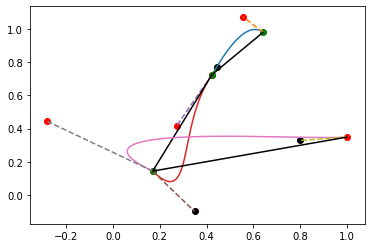

[-0.21881393 -0.25357872  0.8302659 ]
[-0.2552514 -0.5817951  0.204965 ]
[0.37528622 0.5410164  0.6324703 ]
[0.14413784 0.47559497 0.23688681]
[1.6902797  0.04441974 2.3129952 ]
[0.2535788  2.0959244  0.14199474]
[1, 0, 0]


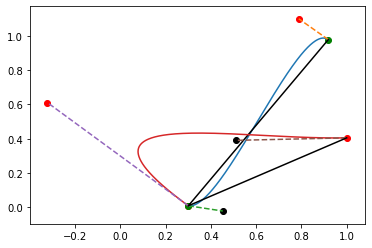

[-0.61875  0.7    ]
[-0.97186    0.3973919]
[0.15501373 1.0779892 ]
[0.1350504 0.6071424]
[1.7548288 1.8555552]
[1.2025254 0.4863974]
[0, 0]


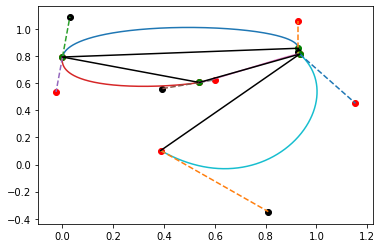

[-0.9283668   0.5386819   0.39541548 -0.5472779 ]
[-0.06476682 -0.18782383  0.20984453 -0.7124352 ]
[0.21362486 0.45383584 0.14452162 0.4728147 ]
[0.32096928 0.26612306 0.0366647  0.6889348 ]
[1.6404474  1.3333036  0.18713164 1.1978647 ]
[1.4031478  0.63645846 1.5158753  1.732907  ]
[1, 1, 1, 0]


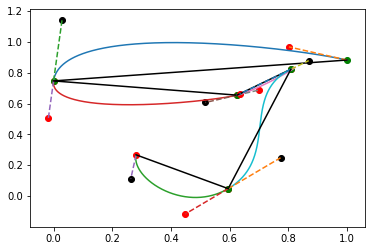

[-1.          0.6256281   0.18341714 -0.21356785 -0.31407037]
[-0.13536203 -0.09233999  0.1678909  -0.77439666  0.21930745]
[0.21340093 0.38283265 0.33333328 0.29587418 0.5801968 ]
[0.3938409  0.18616067 0.33333343 0.33376953 0.40395382]
[0.5423618  1.4974284  0.32580715 0.5586115  1.4525632 ]
[1.3630834  0.5621278  3.1315691  0.45871392 1.0775146 ]
[1, 1, 1, 1, 0]


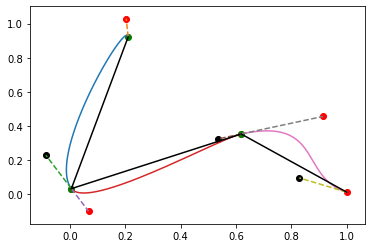

[-0.2054176  0.6139955  0.3814898]
[-0.890625    0.32091346 -0.34134614]
[0.11803529 0.21126373 0.61330277]
[0.23690034 0.12859398 0.3723018 ]
[2.8502066 1.6134374 1.0649403]
[0.6656592  0.14670616 0.27588826]
[1, 1, 0]


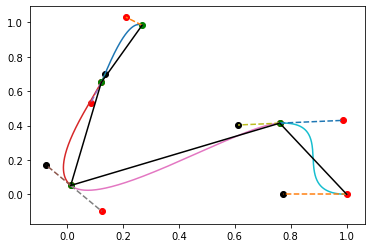

[-0.14578588 -0.10933941  0.7471526   0.23917997]
[-0.33221477 -0.5995526   0.36241612 -0.41387025]
[0.20642674 0.20334141 0.22499527 0.47321466]
[0.13423647 0.2427139  0.17995183 0.4746166 ]
[1.843131   0.12561867 1.3850143  1.1185197 ]
[0.10815022 0.8178065  0.37990934 1.0467829 ]
[1, 1, 1, 0]


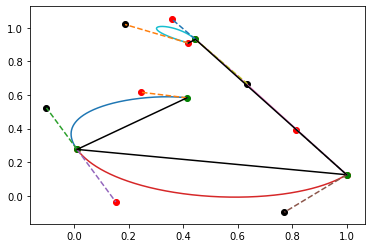

[-0.40314138  0.9895288  -0.55497384 -0.02617803]
[-0.30662984 -0.15055248  0.8052486  -0.02209944]
[0.33798543 0.34287268 0.33333334 4.3316317 ]
[0.53615385 0.3188729  0.33333337 7.513975  ]
[0.84559745 0.99291486 0.00246706 1.64753   ]
[1.3474423  0.92429703 0.02107935 1.9970895 ]
[1, 0, 1, 0]


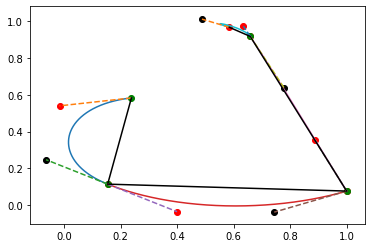

[-0.08415842  0.84653467 -0.34158415 -0.07425743]
[-0.4697885  -0.03776435  0.84290034  0.04984891]
[0.5410215  0.34000304 0.3333333  0.67846   ]
[0.5360164  0.33176702 0.33333334 1.1891245 ]
[1.2256149  0.50336444 0.00273311 0.5755075 ]
[1.2001224  0.46538946 0.01953675 2.9789903 ]
[1, 0, 1, 0]


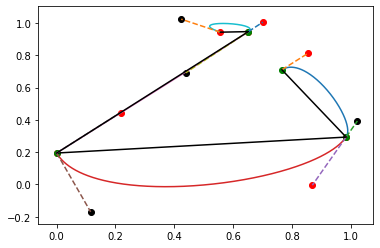

[ 0.21846151 -0.9846154   0.6523077  -0.0953846 ]
[-0.41710758 -0.09876545  0.7522046  -0.00352734]
[0.28778028 0.32270193 0.33333334 0.7998077 ]
[0.22672318 0.38648486 0.33333337 1.6282736 ]
[1.9418141  1.1029332  0.00242325 2.3043125 ]
[0.85037774 1.3636076  0.01788131 2.5604138 ]
[1, 0, 1, 0]


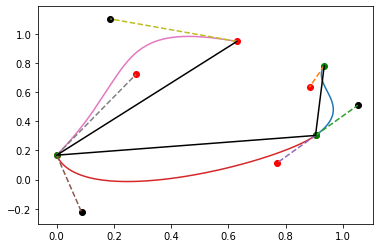

[-0.03053433 -0.9045802   0.629771  ]
[-0.47904763 -0.13523808  0.78      ]
[0.32615107 0.25545985 0.618438  ]
[0.53022814 0.4376015  0.46695772]
[0.27172226 0.8029892  0.21531844]
[0.5557669 1.500128  1.2276423]
[1, 0, 0]


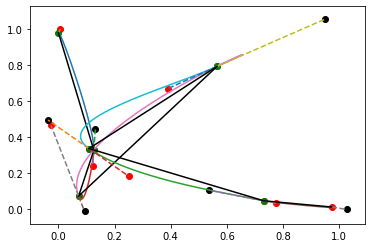

[ 0.1262136  -0.05436894  0.49320385 -0.45631066  0.62330097  0.24077666]
[-0.65432096 -0.25514406  0.72153634 -0.45679012 -0.29080933 -0.03429355]
[0.03099086 0.3333333  0.46337232 0.33333334 0.3066249  0.17865342]
[0.17398696 0.3333333  0.5334966  0.3333334  0.29756323 0.231057  ]
[2.5899832  0.16429074 0.844391   0.17295033 0.39046246 0.1521674 ]
[0.23653218 2.6867611  2.7700615  1.5286815  0.14356436 3.0352383 ]
[1, 1, 0, 1, 1, 0]


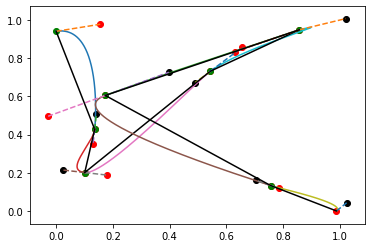

[ 0.13596492 -0.03508772  0.44298247  0.3135965  -0.68421054  0.5833333
  0.23245615]
[-0.5137255  -0.22614379  0.530719    0.21699345 -0.34379083 -0.47189546
 -0.13333334]
[0.30097476 0.33333337 0.11345381 0.44401774 0.33333337 0.30508924
 0.11860951]
[0.15316463 0.33333334 0.11602931 0.4587801  0.33333334 0.07545733
 0.2088325 ]
[1.5461258  0.0791161  1.043962   0.23263685 0.00317498 1.9658538
 0.03499311]
[0.33433753 1.5560368  0.03786493 2.8797038  0.03010724 0.19099846
 1.7479801 ]
[1, 1, 1, 0, 1, 1, 0]


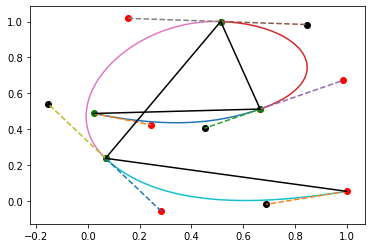

[ 0.6428572  -0.15259743 -0.4448052   0.9318182 ]
[ 0.02459016  0.48711944 -0.76112413 -0.18384075]
[0.35719383 0.7034312  0.4047336  0.38359582]
[0.37336347 0.6579068  0.42833084 0.3359122 ]
[0.3177897 1.4124434 1.0918741 0.744328 ]
[0.42371684 1.2172666  1.1605561  0.42341164]
[1, 1, 1, 0]


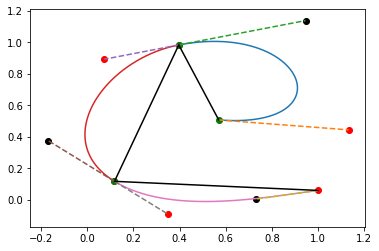

[-0.17337465 -0.27863777  0.88235295]
[ 0.47635525 -0.86620533 -0.05767013]
[1.1178617  0.3689627  0.35254297]
[1.1266148  0.42593333 0.3108802 ]
[2.031155  0.9855426 0.6669876]
[1.4957722 1.1497709 0.2673862]
[1, 1, 0]


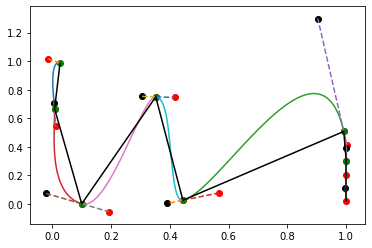

[-0.01845638  0.09228188  0.25167784  0.09228188  0.5469799   0.00838923
  0.        ]
[-0.3193069  -0.6658416   0.75       -0.7252475   0.48267326 -0.21039602
 -0.27970296]
[0.16032487 0.17675285 0.13543847 0.08834537 0.18265255 0.44041112
 0.33346382]
[0.12201627 0.21233982 0.06036913 0.07882607 1.0911344  0.43700013
 0.33360532]
[2.1906054  0.10868423 1.7882053  1.3801844  0.3241535  0.07194801
 0.01241764]
[0.08779769 0.89191353 1.3110946  1.8431296  2.1827335  0.04970373
 0.03864654]
[1, 1, 1, 1, 1, 1, 0]


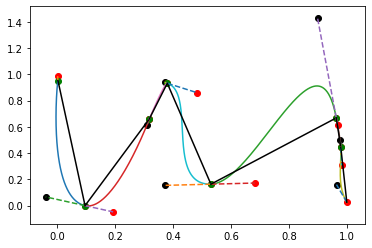

[0.09342561 0.2214533  0.06228372 0.15051904 0.43252593 0.01557094
 0.02076125]
[-0.9512894   0.6590258   0.2722063  -0.76790833  0.50429803 -0.22349572
 -0.4183381 ]
[0.03549878 0.15529862 0.00999303 0.15729515 0.22920948 0.25244537
 0.3283325 ]
[0.15817878 0.0693982  0.0394272  0.20395947 1.1443614  0.24409375
 0.33188146]
[3.0787086  1.7028091  0.08455265 0.76831704 0.80482334 0.01978405
 0.02812553]
[1.0167139  0.16716169 1.9546603  1.4342866  2.3478165  0.04915924
 0.2087598 ]
[1, 1, 1, 1, 1, 1, 0]


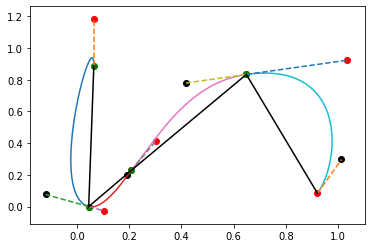

[-0.01966292  0.16292134  0.44101125  0.2724719 ]
[-0.8872549   0.22794117  0.60539216 -0.75      ]
[0.3369602  0.23784383 0.27435675 0.49582255]
[0.20464444 0.11689082 0.31699422 0.2914261 ]
[3.1192653  1.3829855  0.15695658 1.4509381 ]
[1.16022    0.14862335 0.71261096 0.75438416]
[1, 1, 1, 0]


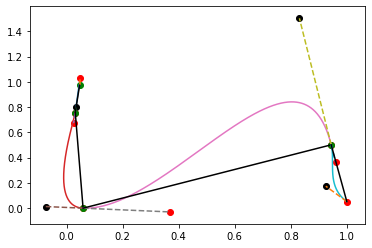

[-0.01547988  0.02786378  0.88544893  0.05572754]
[-0.21640092 -0.7562642   0.5011389  -0.44874713]
[0.2516238  0.11025938 0.30469683 0.30431852]
[0.19276594 0.17749    0.99032587 0.31531414]
[3.0690107  0.10838545 0.6107034  0.01217213]
[0.0148461 1.4382943 1.9730381 0.4298773]
[1, 1, 1, 0]


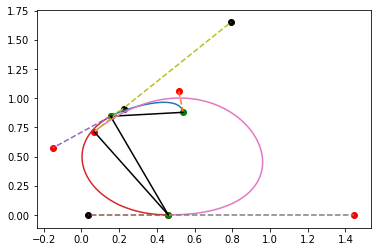

[-0.38482383  0.30623305 -0.39295393]
[-0.03370786 -0.8449438   0.71235955]
[0.46910915 0.45524302 1.2107908 ]
[0.2542777  0.47316188 1.4579742 ]
[1.5318993 1.1936159 2.0748842]
[0.6375523 1.2230921 1.9794116]
[1, 1, 0]


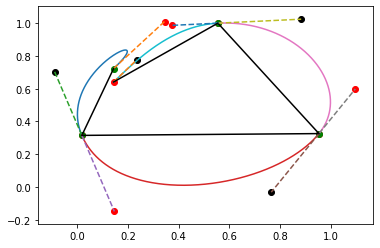

[-0.12525667  0.9342916  -0.39835727 -0.41067764]
[-0.40821916  0.01095891  0.6739726  -0.35890412]
[0.8198867  0.5151841  0.39318275 0.33237305]
[0.9471688  0.43219003 0.42052495 0.30155244]
[2.8288853 1.3131126 1.0178634 0.6442483]
[0.5671399 1.0750266 1.1109687 0.2605033]
[1, 1, 1, 0]


In [6]:
#Read Uji data file and Extract out the data
x_data,y_databef= ParseFile("C:\\Users\\RAJAT BHARDWAJ\\Desktop\\project\\ujipenchars2.txt")
#print( x_data, y_databef)
charlist=list(set(y_databef)) 
charlist.sort()
#time variable is used to seperate elements of text
time = 0;
chardict={}
reversechardict={}
for i in range(len(charlist)):
    chardict[i]=charlist[i]
    reversechardict[charlist[i]]=i
    
y_data=[]
for val in y_databef:
    y_data.append(reversechardict[val])

y_data=np.asarray(y_data)



for i in range(len(x_data)):
    dx_sentence = []
    dy_sentence = []
    d1_sentence = []
    d2_sentence = []
    alpha1_sentence = []
    alpha2_sentence = []
    pen_ups = []
    #print(type(np.asarray(x_train[i])))
    if(len(x_data[i])>250):
        print(y_databef[i],len(x_data[i]))
    x_data[i]=preprocess(np.asarray(x_data[i],dtype=np.float32) )
    x_val = x_data[i][:,0]
    y_val = x_data[i][:,1]
    pen   = x_data[i][:,2]
    #print(pen)
    #plt.plot(x_val, y_val)
    #plt.show()    
    points = []
    pts=[]
    mypoints = set([])
    for j in range(len(x_val)):
        each = []
        each.append(x_val[j])
        each.append(y_val[j])
        p = tuple(each)
        if p in mypoints:
            continue
        points.append(each)
        mypoints.add(p)
        if pen[j]==-2:
            pts.append(points)
            tempr = points[len(points)-1]
            points=[tempr]
            #mypoints.clear()
            #print("kkkk")
    pts.append(points)
    #print(pts)
    trr=0
    for pp in pts:
        trr=trr+1
        #print(trr)
        poin = np.array(pp)
        #print(len(poin))
        bezier = []
        # We let Maxerror to be 0.25 Can be changed.
        beziers = fitCurve(poin, 0.01)
        #print(beziers)
        for bezier in beziers:
            #print(bezier)
            xPoints = np.array([p[0] for p in bezier])
            yPoints = np.array([p[1] for p in bezier])
            #print(xPoints)
            #print(yPoints)
            #xvals, yvals = bezier_curve(bezier, nTimes=1000)
            #plt.plot(xvals, yvals )
            #plt.plot(xPoints, yPoints, "ro")
            x_values = [bezier[0][0],bezier[1][0]]
            y_values = [bezier[0][1],bezier[1][1]]
            x_values1 = [bezier[3][0],bezier[2][0]]
            y_values1 = [bezier[3][1],bezier[2][1]]
            x_values2 = [bezier[3][0],bezier[0][0]]
            y_values2 = [bezier[3][1],bezier[0][1]]
            a1 = np.array([bezier[1][0],bezier[1][1]])
            b1 = np.array([bezier[2][0],bezier[2][1]])
            c1 = np.array([bezier[0][0],bezier[0][1]])
            c2 = np.array([bezier[3][0],bezier[3][1]])
            xvals, yvals = bezier_curve(bezier, nTimes=1000)

            plt.plot(xvals, yvals)
            plt.scatter(bezier[1][0], bezier[1][1],color='red')
            plt.scatter(bezier[2][0], bezier[2][1],color='black')
            plt.scatter(bezier[3][0], bezier[3][1],color='red')
            plt.scatter(bezier[0][0], bezier[0][1],color='green')
            plt.plot(x_values,y_values,'--')
            plt.plot(x_values1,y_values1,'--')
            plt.plot(x_values2,y_values2,color='black')
            #plt.show()
            dx_temp = bezier[3][0] - bezier[0][0]
            dx_sentence.append(dx_temp)
            dy_sentence += [bezier[3][1] - bezier[0][1]]
            c1_dist = sqrt((bezier[0][0] - bezier[1][0])**2 + (bezier[0][1] - bezier[1][1])**2)
            c2_dist = sqrt((bezier[3][0] - bezier[2][0])**2 + (bezier[3][1] - bezier[2][1])**2)
            chord_dist = sqrt((bezier[3][0] - bezier[0][0])**2 + (bezier[3][1] - bezier[0][1])**2)
            pen_ups += [1]

            ba = a1 - c1
            bc = c2 - c1
            cosine_angle = np.dot(ba, bc) / ((np.linalg.norm(ba) * np.linalg.norm(bc)+0.000001))
            angle1 = np.arccos(cosine_angle)

            ba = b1 - c2
            bc = c1 - c2
            cosine_angle = np.dot(ba, bc) / ((np.linalg.norm(ba) * np.linalg.norm(bc)+0.000001))
            angle2 = np.arccos(cosine_angle)

            d1_sentence += [c1_dist/chord_dist]
            d2_sentence += [c2_dist/chord_dist]
            alpha1_sentence += [angle1]
            alpha2_sentence += [angle2]
            #To Introduce Control Points, Uncomment Below two lines.
            #for nr in range(len(bezier)):
                #plt.text(bezier[nr][0], bezier[nr][1], nr)   
         #   break            
        #plt.show()        
        pen_ups[-1] = 0

    
    dx_sentenc = np.asarray(dx_sentence, dtype=np.float32)
    dy_sentenc = np.asarray(dy_sentence, dtype=np.float32)
    d1_sentenc = np.asarray(d1_sentence, dtype=np.float32)
    d2_sentenc = np.asarray(d2_sentence, dtype=np.float32)
    alpha1_sentenc = np.asarray(alpha1_sentence, dtype=np.float32)
    alpha2_sentenc = np.asarray(alpha2_sentence, dtype=np.float32) 


    plt.show()

    print(dx_sentenc)
    print(dy_sentenc)
    print(d1_sentenc)
    print(d2_sentenc)
    print(alpha1_sentenc)
    print(alpha2_sentenc)
    print(pen_ups)
    
    time=time+1
    if(time==100):
        break
    
    